In [ ]:
'''
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
'''



# 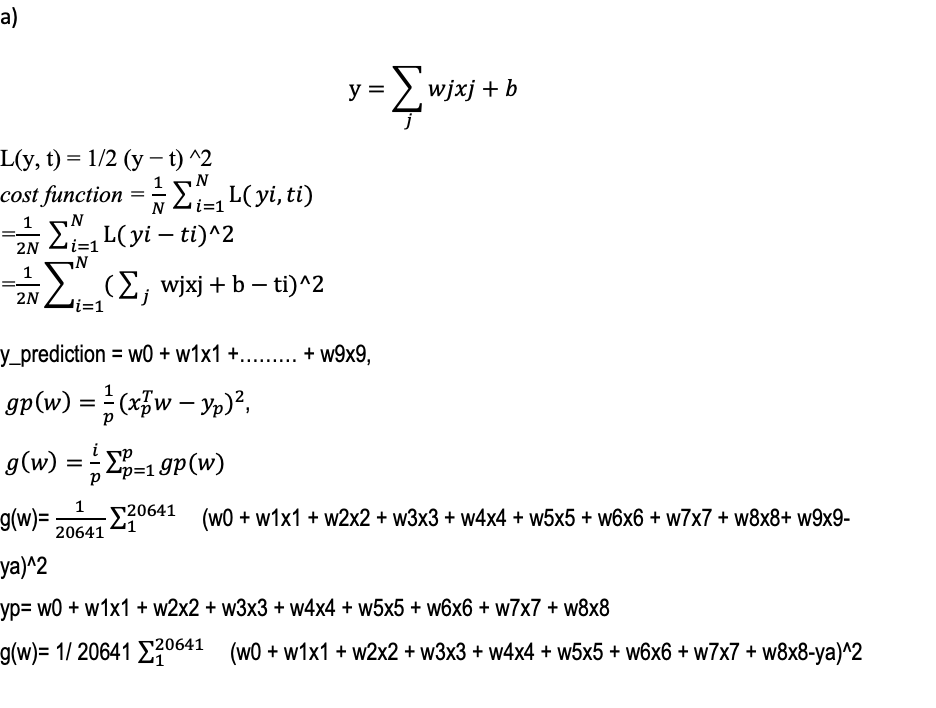


# 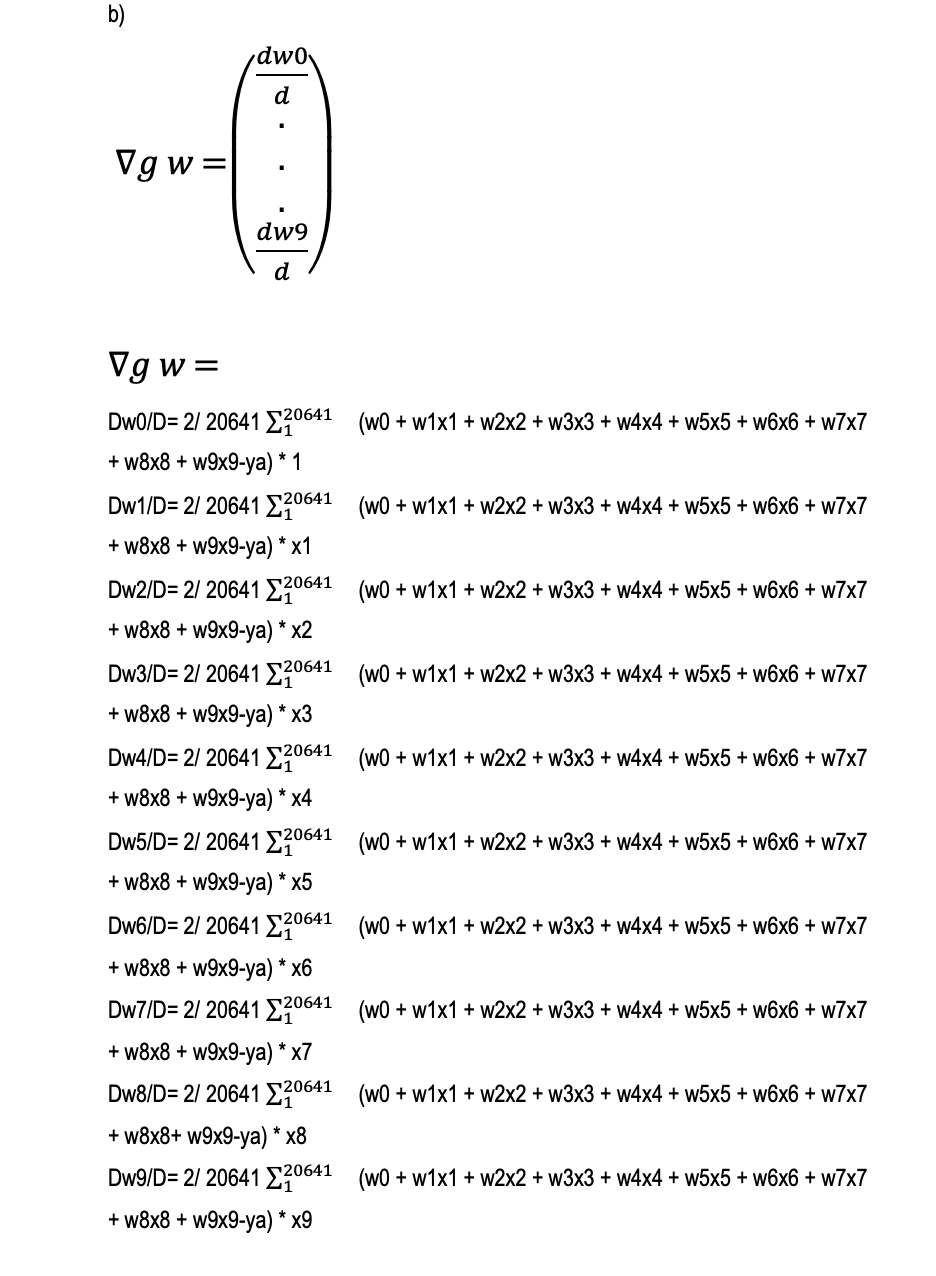

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv("/kaggle/input/california-housing-prices/housing.csv")

# Data preprocessing

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df["ocean_proximity"].value_counts()

In [ ]:
df.describe()

In [ ]:
df.hist(bins=50,figsize=(20,15))

In [ ]:
df.plot(kind="scatter", x="longitude", y="latitude", 
             alpha=0.1, s=df["population"]/100, label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"))

In [ ]:
df.corr()

In [ ]:
corr_matrix=df.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

In [ ]:
housing_na=df.dropna(subset=["total_bedrooms"])#here I am dropping th eobservations with missing values for total_bedrooms
housing_na.shape

In [ ]:
#here is how to turn category variables into bianary vairiables
dummies=pd.get_dummies(housing_na.ocean_proximity)
dummies.head()
df = pd.concat([housing_na, dummies], axis='columns')
df.head()
df = df.drop(['ocean_proximity', 'ISLAND'], axis='columns')
df.head()

In [ ]:

# Outlier handling

# Define a function to check for outliers in a column using IQR method
def check_outliers(column):
    q1, q3 = column.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

In [ ]:

# assuming 'df' is your DataFrame containing the data
num_cols = len(df.columns)
num_rows = (num_cols + 2) // 3  # ceil(num_cols / 3)

fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))
for i, col in enumerate(df.columns):
    row_idx = i // 3
    col_idx = i % 3
    axs[row_idx, col_idx].boxplot(df[col])
    axs[row_idx, col_idx].set_title(col)

# remove empty subplots
for i in range(num_rows*3 - num_cols):
    row_idx = num_rows - 1
    col_idx = num_cols % 3 + i
    axs[row_idx, col_idx].set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
# Define a function to remove outliers in a column using IQR method
def remove_outliers(column):
    q1, q3 = column.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    cleaned_column = column[(column >= lower_bound) & (column <= upper_bound)]
    return cleaned_column

In [ ]:
# Apply the remove_outliers function to each column
for col in df.columns:
    df[col] = remove_outliers(df[col])
    
print('Outliers Removed.')

In [ ]:
# Loop through each column of the DataFrame and check for outliers
for column in df.columns:
    outliers = check_outliers(df[column])
    if not outliers.empty:
        print(f"Column {column} has {len(outliers)} outliers: {outliers.values}")
    else:
        print(f"Column {column} has no outliers.")
        
df = df.fillna(value=0) # replace NaN with 0

# Data splting

In [ ]:
X=df.drop(['median_house_value'], axis='columns').values 
y=df['median_house_value'].values 

In [ ]:
print(X.shape)

In [ ]:
print(y.shape)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.2, 
                                                    random_state=0)

In [ ]:
# Create a StandardScaler object
scaler = StandardScaler()
# Standardize the features in the training set by fitting the scaler to X_train 
# and transforming X_train with the scaler's mean and standard deviation
X_train = scaler.fit_transform(X_train)
# Standardize the features in the test set using the mean and standard deviation
# from the training set, without refitting the scaler
X_test = scaler.transform(X_test)

# e) full,mini and stochastic cost

In [ ]:
def full_mini_batch_cost_function(X, y, w):
    y_pred = X @ w  # compute the predicted target variable as a linear combination of input features and weights
    cost = np.mean((y - y_pred)**2)  # compute the mean squared error between predicted and actual target variable
    grad = -2 * X.T @ (y - y_pred) / len(y) # compute the gradient of the cost function w.r.t. weight vector
    # multiplying by -2 is just a constant factor that simplifies the gradient calculation and doesn't affect the optimal weight vector
    return cost, grad  # return the cost and gradient


In [ ]:
def stochastic_cost_function(x, y, w):
    y_pred = np.dot(x, w)  # compute the predicted target variable as a linear combination of input features and weights
    cost = (y - y_pred)**2  # compute the squared error between predicted and actual target variable
    grad = -2 * (y - y_pred) * x # compute the gradient of the cost function w.r.t. weight vector
    # multiplying by -2 is just a constant factor that simplifies the gradient calculation and doesn't affect the optimal weight vector
    return cost, grad  # return the cost and gradient

In [ ]:
def gradient_descent(X, y, learning_rate, num_iterations, batch_size=None, stochastic=True, epochs=None):
    # Initialize the weight vector w to zeros
    w = np.zeros(X.shape[1])
    # Create an empty list to store the cost values at each iteration
    costs = []
    # If batch_size is None and stochastic is False, use Full-batch and num_iterations
    if batch_size is None and not stochastic:
        # Iterate for the given number of iterations
        for i in range(num_iterations):
            # Use the full dataset for training
            X_batch, y_batch = X, y
            # Compute the cost and gradient using the current weights and the full dataset
            cost, grad = full_mini_batch_cost_function(X_batch, y_batch, w)
            # Update the weights using the gradient and learning rate
            w -= learning_rate * grad
            # Append the cost value to the list of costs
            costs.append(cost)
    # If batch_size is defined, use mini-batch with epochs
    elif batch_size is not None:
        # If epochs is not provided, set it to 1
        if epochs is None:
            epochs = 1
        # Iterate for the given number of epochs
        for epoch in range(epochs):
            rand_idx = np.random.choice(len(y), size=batch_size, replace=True)
            X_batch, y_batch = X[rand_idx], y[rand_idx]
            # Compute the cost and gradient using the current weights and the current subset of data
            cost, grad = full_mini_batch_cost_function(X_batch, y_batch, w)
            # Update the weights using the gradient and learning rate
            w -= learning_rate * grad
            # Append the cost value to the list of costs
            costs.append(cost)
    # If stochastic is True, use stochastic with epochs
    elif stochastic:
        # If epochs is not provided, set it to 1
        if epochs is None:
            epochs = 1
        # Iterate for the given number of epochs
        for epoch in range(epochs):
            # Sample a random subset of the data for each iteration (without replacement)
            rand_idx = np.random.choice(len(y), size=len(y), replace=False)
            X_batch, y_batch = X[rand_idx], y[rand_idx]
            # Iterate for the given number of iterations
            for i in range(num_iterations):
                # Sample a single data point
                idx = np.random.randint(len(y))
                x_i, y_i = X_batch[idx], y_batch[idx]
                # Compute the cost and gradient using the current weights and the current data point
                cost, grad = stochastic_cost_function(x_i, y_i, w)
                # Update the weights using the gradient and learning rate
                w -= learning_rate * grad
                # Append the cost value to the list of costs
                costs.append(cost)
    # Return the final weight vector and the list of costs
    return w, costs

In [ ]:
# Train the model using full batch, mini-batch, and stochastic gradient descent
w_full, _ = gradient_descent(X_train, y_train, learning_rate=0.1, num_iterations=10, batch_size=None, stochastic=False)
w_mini, _ = gradient_descent(X_train, y_train, learning_rate=0.1, num_iterations=10, batch_size=4, stochastic=False, epochs=5)
w_stoch, _ = gradient_descent(X_train, y_train, learning_rate=0.5, num_iterations=10, batch_size=None, stochastic=True, epochs=5)

In [ ]:
y_pred_train_full = X_train @ w_full
y_pred_train_mini = X_train @ w_mini
y_pred_train_stoch = X_train @ w_stoch
mse_train_full = mean_squared_error(y_train, y_pred_train_full)
mse_train_mini = mean_squared_error(y_train, y_pred_train_mini)
mse_train_stoch = mean_squared_error(y_train, y_pred_train_stoch)

y_pred_test_full = X_test @ w_full
y_pred_test_mini = X_test @ w_mini
y_pred_test_stoch = X_test @ w_stoch
mse_test_full = mean_squared_error(y_test, y_pred_test_full)
mse_test_mini = mean_squared_error(y_test, y_pred_test_mini)
mse_test_stoch = mean_squared_error(y_test, y_pred_test_stoch)

In [ ]:
print("Mean Squared Error on Training Set:")
print(f"Full Batch Gradient Descent: {mse_train_full}")
print(f"Mini-Batch Gradient Descent: {mse_train_mini}")
print(f"Stochastic Gradient Descent: {mse_train_stoch}")

print("Mean Squared Error on Test Set:")
print(f"Full Batch Gradient Descent: {mse_test_full}")
print(f"Mini-Batch Gradient Descent: {mse_test_mini}")
print(f"Stochastic Gradient Descent: {mse_test_stoch}")

# calculate the gradient

In [ ]:
def calculate_gradient(X, y, w):
    m = X_train.shape[0]
    y_pred = np.dot(X, w)
    error = y_pred - y_train
    grad = (2/m) * np.dot(X_train.T, error)
    return grad

# d1) steepest descent

In [ ]:
def steepest_descent(X, y, learning_rate=0.1, num_iterations=10):
    alpha=learning_rate
    w = np.zeros(X.shape[1])
    for i in range(num_iterations):
        grad = calculate_gradient(X, y, w)
        w = w - alpha * grad
    return w

In [ ]:
w_ssd = steepest_descent(X_train, y_train)

In [ ]:
y_pred_train_ssd = X_train @ w_ssd
mse_train_ssd = mean_squared_error(y_train, y_pred_train_ssd)

y_pred_test_ssd = X_test @ w_ssd
mse_test_ssd = mean_squared_error(y_test, y_pred_test_ssd)

In [ ]:
print("Mean Squared Error on Training Set:")
print(f"steepest_descent Batch Gradient Descent: {mse_train_ssd}")


print("Mean Squared Error on Test Set:")
print(f"steepest_descent Batch Gradient Descent: {mse_test_ssd}")


# d2) Adagrad

In [ ]:
def adagrad(X, y, learning_rate=0.1, num_iterations=10,eps=1e-8):
    alpha=learning_rate
    w = np.zeros(X.shape[1])
    grad_squared_sum = np.zeros(X.shape[1])
    for i in range(num_iterations):
        grad = calculate_gradient(X, y, w)
        grad_squared_sum += grad**2
        w = w - alpha * grad / (np.sqrt(grad_squared_sum) + eps)
    return w

In [ ]:
w_adagrad = adagrad(X_train, y_train)

In [ ]:
y_pred_train_adagrad = X_train @ w_adagrad
mse_train_adagrad = mean_squared_error(y_train, y_pred_train_adagrad)

y_pred_test_adagrad = X_test @ w_adagrad
mse_test_adagrad = mean_squared_error(y_test, y_pred_test_adagrad)

In [ ]:
print("Mean Squared Error on Training Set:")
print(f"adagrad Batch Gradient Descent: {mse_train_adagrad}")


print("Mean Squared Error on Test Set:")
print(f"adagrad Batch Gradient Descent: {mse_test_adagrad}")

# d3) RMSprop

In [ ]:
def RMSprop(X, y, learning_rate=0.1, num_iterations=10,beta=0.9,eps=1e-8):
    alpha=learning_rate
    w = np.zeros(X.shape[1])
    grad_squared_avg = np.zeros(X.shape[1])
    for i in range(num_iterations):
        grad = calculate_gradient(X, y, w)
        grad_squared_avg = beta * grad_squared_avg + (1 - beta) * grad**2
        w = w - alpha * grad / (np.sqrt(grad_squared_avg) + eps)
    return w

In [ ]:
w_RMSprop = RMSprop(X_train, y_train)

In [ ]:
y_pred_train_RMSprop = X_train @ w_RMSprop
mse_train_RMSprop = mean_squared_error(y_train, y_pred_train_RMSprop)

y_pred_test_RMSprop = X_test @ w_RMSprop
mse_test_RMSprop = mean_squared_error(y_test, y_pred_test_RMSprop)

In [ ]:
print("Mean Squared Error on Training Set:")
print(f"RMSprop Batch Gradient Descent: {mse_train_RMSprop}")


print("Mean Squared Error on Test Set:")
print(f"RMSprop Batch Gradient Descent: {mse_test_RMSprop}")

# f)
# To know if we can apply Newton’s method,
# 1.Determine if the cost function is convex, Convexity indicates that the cost function has one global minimum. I will check convexity by examining the second derivative of the cost function or by performing a mathematical analysis of the problem.
# 2. We need to calculate Hessian  Matrix and Check Positive Semi-Definite: Check if the Hessian  matrix is positive semi-definite. A matrix is positive quasi-definite if all of its eigenvalues are non-negative. I will calculate the eigenvalues of the Hessian matrix and check if they satisfy this condition.

In [ ]:
def cost_function(X, y,w):
    y_pred = np.dot(X, params)
    mse = np.mean((y_pred - y)**2)
    return mse

In [ ]:
def second_derivative(X, y,w , i, j):
    n = len(y)
    derivative = np.mean(X[:, i] * X[:, j])
    return derivative

In [ ]:
def hessian_matrix(X, y,w):
    n = len(w)
    hessian = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            hessian[i, j] = hessian[j, i] = second_derivative(X, y,w,  i, j)
    return hessian

In [ ]:
w = np.zeros(X.shape[1])
hessian = hessian_matrix(X_train, y_train,w)

In [ ]:
n = len(w)
hessian = np.zeros((n, n))
for i in range(n):
    for j in range(i, n):
        hessian[i, j] = hessian[j, i] = second_derivative(X_train, y_train,w,  i, j)
        print(hessian[i, j])

In [ ]:
print("Hessian matrix:")
print(hessian)

 # f) As the result we can't use Newton’s method to minimize the cost function becouse the function is not convex, As there is more than 1 value is Smaller than zero

# g) best performance

In [ ]:
# Dictionary containing the MSE values for each algorithm
mse_values = {
    'full batch Descent': (mse_train_full, mse_test_full),
    'mini batch Descent': (mse_train_mini, mse_test_mini),
    'Stochastic Gradient Descent': (mse_train_stoch, mse_test_stoch),
    'Steepest Descent': (mse_train_ssd, mse_test_ssd),
    'Adagrad': (mse_train_adagrad, mse_test_adagrad),
    'RMSprop': (mse_train_RMSprop, mse_test_RMSprop)
}

best_algorithm = None
lowest_mse = float('inf') 

for algorithm, (train_mse, test_mse) in mse_values.items():
    if test_mse < lowest_mse:
        lowest_mse = test_mse
        best_algorithm = algorithm

print("The best optimization algorithm is:", best_algorithm)


In [ ]:
# Dictionary containing the MSE values for each algorithm
mse_values = {
    'Stochastic Gradient Descent': (mse_train_stoch, mse_test_stoch),
    'Steepest Descent': (mse_train_ssd, mse_test_ssd),
    'Adagrad': (mse_train_adagrad, mse_test_adagrad),
    'RMSprop': (mse_train_RMSprop, mse_test_RMSprop)
}

best_algorithm = None
lowest_mse = float('inf') 

for algorithm, (train_mse, test_mse) in mse_values.items():
    if test_mse < lowest_mse:
        lowest_mse = test_mse
        best_algorithm = algorithm

print("The best optimization algorithm is:", best_algorithm)

# The best optimization algorithm is: Full Batch Gradient Descen,
# The best optimization algorithm from the stochastic standard steepest descent, Adagrad and RMSprop is standard steepest descent

In [ ]:
alphas=[0.1,0.2,0.3,0.6,0.7,0.8,0.9]

In [ ]:
bestofbest=[]

In [ ]:
for alpha in alphas:
    w_full, _ = gradient_descent(X_train, y_train, learning_rate=alpha, num_iterations=10, batch_size=None, stochastic=False)
    w_mini, _ = gradient_descent(X_train, y_train, learning_rate=alpha, num_iterations=10, batch_size=4, stochastic=False, epochs=5)
    w_stoch, _ = gradient_descent(X_train, y_train, learning_rate=alpha, num_iterations=10, batch_size=None, stochastic=True, epochs=5)
    w_ssd = steepest_descent(X_train, y_train, learning_rate=alpha, num_iterations=10)
    w_adagrad = adagrad(X_train, y_train, learning_rate=alpha, num_iterations=10)
    w_RMSprop = RMSprop(X_train, y_train,learning_rate=alpha, num_iterations=10)
    y_pred_train_full = X_train @ w_full
    y_pred_train_mini = X_train @ w_mini
    y_pred_train_stoch = X_train @ w_stoch
    y_pred_train_ssd = X_train @ w_ssd
    y_pred_train_adagrad = X_train @ w_adagrad
    y_pred_train_RMSprop = X_train @ w_RMSprop
    mse_train_full = mean_squared_error(y_train, y_pred_train_full)
    mse_train_mini = mean_squared_error(y_train, y_pred_train_mini)
    mse_train_stoch = mean_squared_error(y_train, y_pred_train_stoch)
    mse_train_ssd = mean_squared_error(y_train, y_pred_train_ssd)
    mse_train_adagrad = mean_squared_error(y_train, y_pred_train_adagrad)
    mse_train_RMSprop = mean_squared_error(y_train, y_pred_train_RMSprop)
    
    y_pred_test_full = X_test @ w_full
    y_pred_test_mini = X_test @ w_mini
    y_pred_test_stoch = X_test @ w_stoch
    y_pred_test_ssd = X_test @ w_ssd
    y_pred_test_adagrad = X_test @ w_adagrad
    y_pred_test_RMSprop = X_test @ w_RMSprop
    mse_test_full = mean_squared_error(y_test, y_pred_test_full)
    mse_test_mini = mean_squared_error(y_test, y_pred_test_mini)
    mse_test_stoch = mean_squared_error(y_test, y_pred_test_stoch)
    mse_test_ssd = mean_squared_error(y_test, y_pred_test_ssd)
    mse_test_adagrad = mean_squared_error(y_test, y_pred_test_adagrad)
    mse_test_RMSprop = mean_squared_error(y_test, y_pred_test_RMSprop)
    mse_values = {
    'full batch Descent': (mse_train_full, mse_test_full),
    'mini batch Descent': (mse_train_mini, mse_test_mini),
    'Stochastic Gradient Descent': (mse_train_stoch, mse_test_stoch),
    'Steepest Descent': (mse_train_ssd, mse_test_ssd),
    'Adagrad': (mse_train_adagrad, mse_test_adagrad),
    'RMSprop': (mse_train_RMSprop, mse_test_RMSprop)
    }

    best_algorithm = None
    lowest_mse = float('inf') 

    for algorithm, (train_mse, test_mse) in mse_values.items():
        if test_mse < lowest_mse:
            lowest_mse = test_mse
            best_algorithm = algorithm

    bestofbest.append(best_algorithm)
    

In [ ]:
print(bestofbest)
print(alphas)

# As the result when apllying different Learning rate , the Performance change from alpha to another